In [12]:
import sys
import os
import pandas as pd
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import json
import utils
import newEstimator as NE
main_dir = "C:/Users/nourisa/Downloads/testProjs/omics"
sys.path.insert(0,main_dir)
specs = dict(
    o_df_dir = os.path.join(main_dir,'data','original_omics.xlsx'),
    df_dir = os.path.join(main_dir,'data','omics.csv'),
    time = [1,2,3,4,7,8,9,10,11,14,21],
    p_ID = 'Entry',  # The column name in the original data to be used as protein ID
    c_tag = 'ctr_',
    s_tag = 'mg_',
    c_func = lambda t: 'ctr_' + str(t),  # The tag used in the tailored dataframe for control
    s_func = lambda t: 'mg_' + str(t),  # The tag used in the tailored dataframe for sample
    o_c_func = lambda t: 'LogLFQ intensity ' + str(t) + '_0',  # Func to extract the control data from the original database 
    o_s_func = lambda t: 'LogLFQ intensity ' + str(t) + '_1',  # Func to extract the sample data from the original database
    ee = 0.5,  # Threshold for log2FC to retain the data
    min_s = 2,  # Min occurance in time series in order to retain the data  
)
## read the original data
o_df = pd.read_excel(specs['o_df_dir'])
# process the data
o_df_m = utils.rename_missing_symbols(o_df,**specs); 
df = utils.tailor_names(o_df_m, **specs)
df = utils.remove_zeros(df, **specs)
df.to_csv('data/primary_omics.csv')

Remaining missing names:  []
Data size, original: 2562
Data size, rows with all zeros were removed: 2229


C:\Users\nourisa\Downloads\testProjs\omics\utils.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'],axis=1,inplace = True)


In [13]:
# extract sig proteins
df_sig = utils.sig_df(df, **specs)
print('Sig proteins: {}'.format(len(df_sig)))
# impute missing values: available techniques to try: interpolate, univariate and multivariate: https://scikit-learn.org/stable/modules/impute.html
df_interp = df_sig.interpolate() 
df_interp = utils.listwise_deletion(df_interp)
print('Sig interpolated proteins: {}'.format(len(df_interp)))

Sig proteins:  34
Sig proteins: 34
Sig interpolated proteins: 34


In [ ]:
# stats of sig proteins: different time points, unknown proteins

# number of sig proteins for different time points
sig_prot_names = {} 
for day in specs['time']:
    sig_prot_names[day] = utils.sig_test(df,day,**specs)[specs['p_ID']].tolist()
# plot number of sig proteins for measurement times 
fig, axes = plt.subplots(figsize = (15,4), nrows = 1, ncols = 3, tight_layout = True)
def plot_stats_time_1(ax):
    ax.bar(range(len(sig_prot_names)),[len(x) for x in sig_prot_names.values()])
    ax.set_ylabel('Number of proteins')
    ax.set_xlabel('Measurement day')
    ax.set_xticks(range(len(sig_prot_names)))
    _ = ax.set_xticklabels(sig_prot_names.keys())
    ax.set_title('Differentially expressed proteins')
plot_stats_time(axes[0])
#------
# sig incidence number: how many times a protein is detected sig across different time points
limit_n = 3 # if the incidences are below this, dont plot it
sig_prots_e = [x for xx in sig_prot_names.values() for x in xx] # duplicates included
sig_prots = list(set(sig_prots_e)) # duplicates excluded
print('Number of prots upregulated in at least one time point: ',len(sig_prots))
sig_prots_i = {i:sig_prots_e.count(i) for i in sig_prots} # incidences 
sig_prots_i_f = {}
for key,value in sig_prots_i.items():
    if value >= limit_n:
        sig_prots_i_f[key] = value
print('Number of prots upregulated in at least 3 time points: ',len(sig_prots_i_f))
def plot_stats_time_2(ax):
    ax.bar(range(len(sig_prots_i_f)),sig_prots_i_f.values())
    ax.set_ylabel('Number of incidences')
    ax.set_xlabel('Measurement day')
    ax.set_xticks(range(len(sig_prots_i_f)))
    ax.set_xticklabels(sig_prots_i_f.keys())
    ax.set_title('Multiple differentially expressed proteins')
plot_stats_time_2(axes[1])
#----
# sig incidence number for unknown params
unknown_sigs_prots = [x for x in sig_prots if 'p_' in x ]
unknown_sigs_prots_i = {i:sig_prots_e.count(i) for i in unknown_sigs_prots} # incidences 
print('Total number of unknown paramters: ',len([x for x in df[specs['p_ID']].tolist() if 'p_' in x ]))
print('Sig number of unknown paramters: ',len(unknown_sigs_prots))
def plot_stats_time_3(ax):
    ax.bar(range(len(unknown_sigs_prots_i)),unknown_sigs_prots_i.values())
    ax.set_ylabel('Number of incidences')
    ax.set_xticks(range(len(unknown_sigs_prots_i)))
    _ = ax.set_xticklabels(unknown_sigs_prots_i.keys())
    ax.set_title('Multiple differentially expressed proteins')
plot_stats_time_3(axes[2])
#----
# output the name of sig proteins 
def remove_unknown(sig_prot_names):
    sig_prots_time_f = {}
    for key,values in sig_prot_names.items():
        values_f = [x for x in values if x != np.nan]
        _str = ''
        for value in values_f:
            _str += value + '\n'
        sig_prots_time_f[key] = _str
    return sig_prots_time_f
sig_prots_time_f = remove_unknown(sig_prot_names)
with open('results/sig_prots.txt','w') as f:
    for key,value in sig_prots_time_f.items():
        f.write('\n \nday '+ str(key)+': \n'+ value)

In [14]:
# reformat the data for time series
import newEstimator
import importlib
importlib.reload(newEstimator)
df_target = df_interp
time = specs['time']
p_ID = specs['p_ID']
data_ctr = np.array(df_target.loc[:,['ctr_'+str(day) for day in time]].values)
data_mg = np.array(df_target.loc[:,['mg_'+str(day) for day in time]].values)
(TS_data, time_points, decay_rates, gene_names) = \
    [data_ctr.transpose(),data_mg.transpose()], [time,time],[],df_target[p_ID].tolist()
print('n_exp n:',len(TS_data))
print('n_time*n_genes',TS_data[0].shape)

# convert data to n_samples*n_genes format
Xs,ys = NE.process_data(TS_data, time_points, regulators = 'all')
print('n_genes: ',len(ys),len(Xs))
print('n_sample*n_genes : ',Xs[0].shape)
print('n_sample for y : ',len(ys[0]))


n_exp n: 2
n_time*n_genes (11, 34)
n_genes:  34 34
n_sample*n_genes :  (20, 34)
n_sample for y :  20


In [11]:
import numpy as np
n_genes = 3
permts = [{'p1':.08},{'p1':.09}]
all_output = [[1,[[.8,.4,1]]], [0,[[.7, .6, .5]]]] # for different permut
all_output.sort(key = lambda x: x[0])

scores = np.empty([n_genes, 0])
ests = np.empty([n_genes, 0])
for output in all_output: # each output is for a permut
    scores_all_genes, = output[1] # for all genes 
    scores = np.c_[scores, scores_all_genes]
#     ests = np.c_[ests, ests_all_genes]
# for i_gene, item_gene in enumerate(scores):
print(params,'\n')
print(scores,'\n')
best_scores = scores.max(1)
best_indices = np.array(scores.argmax(1))
print('best_indices ' , best_indices)
best_params = [permts[i] for i in best_indices]
best_params

[{'p1': 0.08}, {'p1': 0.09}] 

[[0.7 0.8]
 [0.6 0.4]
 [0.5 1. ]] 

best_indices  [1 0 1]


[{'p1': 0.09}, {'p1': 0.08}, {'p1': 0.09}]

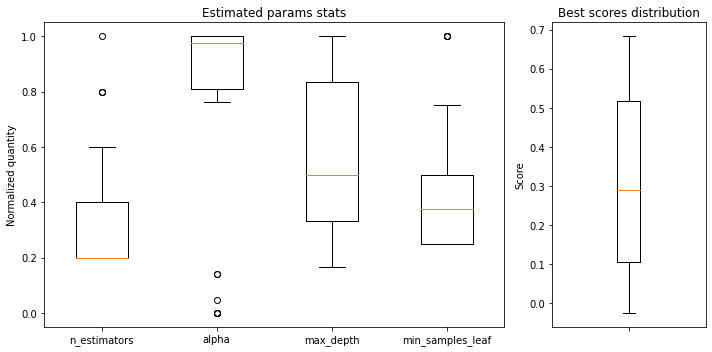

In [34]:
# reload grid search results
import json
import ast
with open('results/grid_search.txt','r') as f:
    outs = ast.literal_eval(f.read())
best_scores, best_params = outs['best_scores'], outs['best_params']
newEstimator.post_grid_search(best_params,best_scores)

In [ ]:
# network inference after training
import importlib
import newEstimator
import utils
importlib.reload(utils)

ests, scores_train, links, oob_scores = newEstimator.network_inference(Xs, ys, param = param, ests = best_ests)
utils.plot_hist(xs = [scores_train,oob_scores], names = ['train', 'test'])

print('train -> mean: %.3f, std: %.3f'%(np.mean(scores_train),np.std(scores_train)))
print('test -> mean: %.3f, std: %.3f'%(np.mean(best_scores),np.std(best_scores)))

In [ ]:
# test SALib 
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}
param_values = saltelli.sample(problem, 1024)

# Y = np.zeros([param_values.shape[0]])
# for i, X in enumerate(param_values):
#     Y[i] = evaluate_model(X)

Y = Ishigami.evaluate(param_values)
print(param_values)
print(min(Y))
Si = sobol.analyze(problem, Y)

total_Si, first_Si, second_Si = Si.to_df()
Si.plot()

In [ ]:
# FFD 
import newEstimator 
import importlib
import numpy as np
importlib.reload(newEstimator)

from SALib.sample.ff import sample as FFD_sample
from SALib.analyze.ff import analyze as FFD_analyze

param = dict(
    estimator_t = 'RF', 
    oob_score = True
)
grid_range = dict(
    max_depth = [5,30],
    n_estimators = [20, 1000],
    alpha = [.001,.9]
)

problem = {
    'num_vars': 3,
    'names': list(grid_range.keys()),
    'bounds': list(grid_range.values())
}

param_values_o = FFD_sample(problem)
param_values = [x[0:3] for x in param_values_o]

Y = []
for param_value in param_values:
    param_value = {key:value for key,value in zip(grid_range.keys(),param_value)}
    param_a = {**param, **param_value}
#     Y.append(newEstimator.evaluate(Xs, ys, param,param_a))
    Y.append(newEstimator.evaluate_single(Xs[0], ys[0], param,param_a)[1])

print(Y)
FFD_analyze(problem, param_values_o, Y,second_order = True)

In [ ]:
# SA
import newEstimator 
import importlib
import numpy as np
importlib.reload(newEstimator)

from SALib.sample import saltelli
from SALib.analyze import sobol

param = dict(
    estimator_t = 'RF', 
    oob_score = True
)
grid_range = dict(
    max_depth = [5,30],
    n_estimators = [20, 1000],
    alpha = [.001,.9]
)

problem = {
    'num_vars': 3,
    'names': list(grid_range.keys()),
    'bounds': list(grid_range.values())
}

param_values_o =  saltelli.sample(problem, 100)
param_values = [x[0:3] for x in param_values_o]

Y = []
for param_value in param_values_o:
    param_value = {key:value for key,value in zip(grid_range.keys(),param_value)}
    param_a = {**param, **param_value}
#     Y.append(newEstimator.evaluate(Xs, ys, param,param_a))
    Y.append(newEstimator.evaluate_single(Xs[0], ys[0], param,param_a)[1])
Y = np.array(Y)
Si = sobol.analyze(problem, Y,parallel = True, n_processors =10)

total_Si, first_Si, second_Si = Si.to_df()
Si.plot()

In [ ]:
# network inference with no training
import importlib
import newEstimator
import utils as ul
importlib.reload(newEstimator)
param = dict(
    estimator_t = 'RF', 
    n_estimators = 100,
    oob_score = True,
    alpha = .1
)
ests, scores_train, links, oob_scores = newEstimator.network_inference(Xs, ys, param = param)
ul.plot_hist(xs = [scores_train,oob_scores], names = ['train', 'test'])
print('train -> mean: %.3f, std: %.3f'%(np.mean(scores_train),np.std(scores_train)))
print('test -> mean: %.3f, std: %.3f'%(np.mean(oob_scores),np.std(oob_scores)))